# **Waste Classification Model**
This is a model to predict whether 'metal', 'cardboard', 'paper', 'plastic', 'glass', 'trash' are [Recyclable or Non- Recyclable] based on images provided.

## **1. Setup and Imports**

In [ ]:
# Run this when disconnected from runtime
base_dir = '/content/drive/MyDrive/Garbage_Classification_Data_Split'
input_data_dir = '/content/drive/MyDrive/Garbage_classification_data'
class_names = os.listdir(input_data_dir)
input_shape = (img_height, img_width, 3)
num_classes = len(class_names)

In [ ]:
# Importing essential libraries
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pickle
import json

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop

from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split


# Sklearn for evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
print('Drive mounted')

Mounted at /content/drive
Drive mounted


## **2. Define and Create Directories for Train, Validation, and Test**

In [ ]:
# The base directory
base_dir = '/content/drive/MyDrive/Garbage_Classification_Data_Split'

# The input data directory
input_data_dir = '/content/drive/MyDrive/Garbage_classification_data'

# Defining directories for train, validation, and test
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Create directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

print("Directories for training, validation, and testing created.")


Directories for training, validation, and testing created.


## **3. Split the Dataset into Train, Validation, and Test Directories**
Splitting the data into 70% training, 15% validation, and 15% testing per class to maintain class distribution.

In [ ]:
# Get Class Names
class_names = os.listdir(input_data_dir)
class_names = [class_name for class_name in class_names
               if os.path.isdir(os.path.join(input_data_dir, class_name))
               and class_name not in ['train', 'validation', 'test']]
print(f"Classes found: {class_names}")

# Split Data into Train, Validation, and Test
for class_name in class_names:
    class_dir = os.path.join(input_data_dir, class_name)
    files = os.listdir(class_dir)

    # Filter out non-file entries
    files = [f for f in files if os.path.isfile(os.path.join(class_dir, f))]

    if not files:
        print(f"No files found in class '{class_name}'. Skipping...")
        continue

    # Shuffle files
    np.random.seed(42)  # For reproducibility
    np.random.shuffle(files)

    # Calculate split sizes
    total = len(files)
    train_size = int(0.7 * total)
    val_size = int(0.15 * total)
    test_size = total - train_size - val_size

    # Split files
    train_files = files[:train_size]
    val_files = files[train_size:train_size + val_size]
    test_files = files[train_size + val_size:]

    # Create class directories in train, validation, and test folders
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Function to copy files safely
    def copy_files(file_list, src_dir, dest_dir, class_name, split_type):
        for file in file_list:
            src_file = os.path.join(src_dir, file)
            dest_file = os.path.join(dest_dir, class_name, file)
            if os.path.isfile(src_file):
                try:
                    shutil.copy(src_file, dest_file)
                except Exception as e:
                    print(f"Error copying {src_file} to {dest_file}: {e}")
            else:
                print(f"Skipping {src_file}, not a file.")

    # Moving files to respective directories
    copy_files(train_files, class_dir, train_dir, class_name, 'train')
    copy_files(val_files, class_dir, val_dir, class_name, 'validation')
    copy_files(test_files, class_dir, test_dir, class_name, 'test')

    print(f"Class '{class_name}' split into Train: {train_size}, Validation: {val_size}, Test: {test_size}")

print("Data split completed.")

Classes found: ['metal', 'cardboard', 'paper', 'plastic', 'glass', 'trash']
Class 'metal' split into Train: 287, Validation: 61, Test: 62
Class 'cardboard' split into Train: 282, Validation: 60, Test: 61
Class 'paper' split into Train: 415, Validation: 89, Test: 90
Class 'plastic' split into Train: 337, Validation: 72, Test: 73
Class 'glass' split into Train: 350, Validation: 75, Test: 76
Class 'trash' split into Train: 95, Validation: 20, Test: 22
Data split completed.


## **4. Load and Preprocess the Dataset Using ImageDataGenerator**

In [ ]:
# 6. Load and Preprocess the Dataset
img_height, img_width = 224, 224
batch_size = 32

# ImageDataGenerator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# ImageDataGenerator for validation and testing (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Validation generator
validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Test generator
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 1766 images belonging to 6 classes.
Found 377 images belonging to 6 classes.
Found 384 images belonging to 6 classes.


## **Display Images**

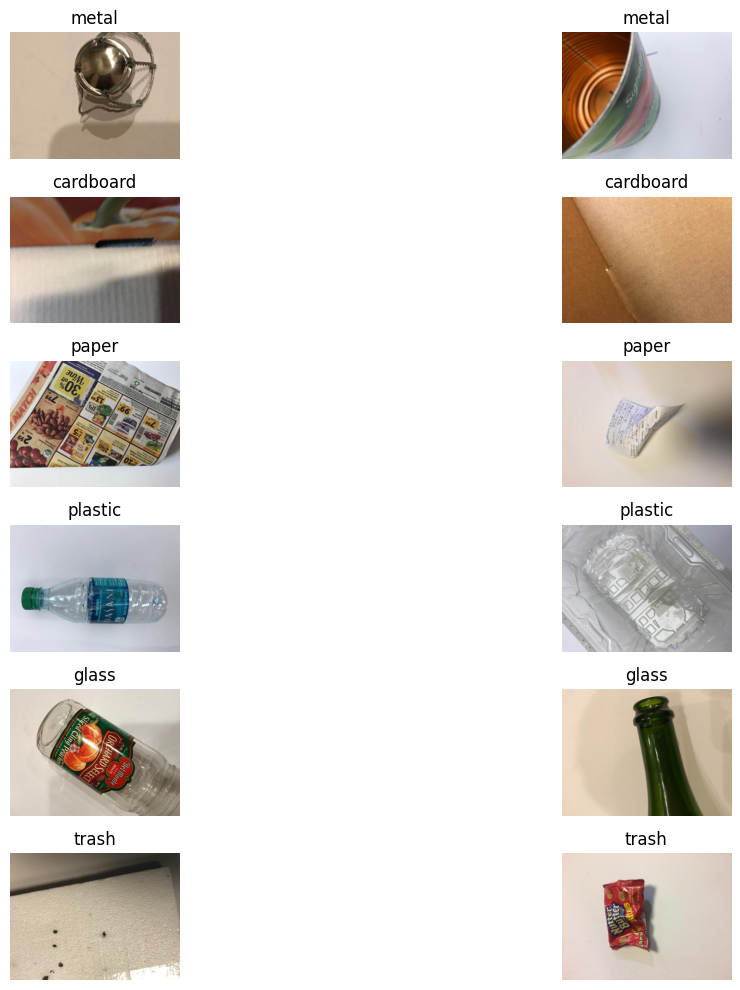

In [ ]:
# The number of images to be displayed for each class
num_images_to_display = 2

# Function to display images from each class
def display_images_from_classes(base_dir, class_names, num_images):
    plt.figure(figsize=(15, 10))

    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(base_dir, class_name)
        images = os.listdir(class_dir)

        # Shuffle images for random display
        np.random.shuffle(images)

        # Display images for each class
        for j in range(min(num_images, len(images))):
            img_path = os.path.join(class_dir, images[j])
            img = mpimg.imread(img_path)
            plt.subplot(len(class_names), num_images, i * num_images + j + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(class_name)

    plt.tight_layout()
    plt.show()

# Display images for each class
display_images_from_classes(train_dir, class_names, num_images_to_display)

## **5. Build the Vanilla/Simple CNN Model**

In [ ]:
# Build the Simple CNN Model
def build_simple_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

input_shape = (img_height, img_width, 3)
num_classes = len(class_names)

simple_cnn = build_simple_cnn(input_shape, num_classes)
simple_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,734 (42.61 MB)

 Trainable params: 11,169,734 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

### **5.1 Train the vanilla model**

In [ ]:
# Train simple CNN
history_simple = simple_cnn.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    verbose=1
)

Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 592ms/step - accuracy: 0.2079 - loss: 2.2854 - val_accuracy: 0.2467 - val_loss: 1.6371
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 69s 487ms/step - accuracy: 0.3125 - loss: 1.5689 - val_accuracy: 0.3475 - val_loss: 1.5353
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 485ms/step - accuracy: 0.3880 - loss: 1.4962 - val_accuracy: 0.3422 - val_loss: 1.5625
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 485ms/step - accuracy: 0.4402 - loss: 1.3927 - val_accuracy: 0.4828 - val_loss: 1.3087
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 483ms/step - accuracy: 0.4707 - loss: 1.3506 - val_accuracy: 0.4403 - val_loss: 1.4244
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 518ms/step - accuracy: 0.5048 - loss: 1.2718 - val_accuracy: 0.4430 - val_loss: 1.3953
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 474ms/step - accuracy: 0.5181 - loss: 1.2027 - val_accuracy: 0.4615 - val_loss: 1.3249
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 477ms/step - accuracy: 0.5361 - loss: 1.1959 - val_accu

In [ ]:
# Define save paths
save_path = '/content/drive/MyDrive/Garbage_Classification_Models'
os.makedirs(save_path, exist_ok=True)

In [ ]:
# Save Simple Model
simple_model_path = os.path.join(save_path, 'simple_cnn.keras')
simple_cnn.save(simple_model_path)
print(f"Simple model saved to {simple_model_path}")

Simple model saved to /content/drive/MyDrive/Garbage_Classification_Models/simple_cnn.keras


In [ ]:
simple_model_path = os.path.join(save_path, 'simple_cnn.keras')

simple_cnn_loaded = tf.keras.models.load_model(simple_model_path)

In [ ]:
# Function to calculate specificity
def calculate_specificity(cm):
    specificity = []
    for i in range(len(cm)):
        TN = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
        FP = np.sum(cm[:, i]) - cm[i, i]
        spec = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificity.append(spec)
    return specificity

# Function to evaluate the model and visualize confusion matrix
def evaluate_model(model, generator, class_names, model_name="Model"):
    generator.reset()
    predictions = model.predict(generator, verbose=0)
    pred_classes = np.argmax(predictions, axis=1)
    true_classes = generator.classes

    # Confusion Matrix
    cm = confusion_matrix(true_classes, pred_classes)
    print(f"\nConfusion Matrix - {model_name}")
    print(cm)

    # Classification Report
    report = classification_report(true_classes, pred_classes, target_names=class_names)
    print(f"\nClassification Report - {model_name}")
    print(report)

    # Specificity
    specificity = calculate_specificity(cm)
    print(f"Specificity - {model_name}")
    for cls, spec in zip(class_names, specificity):
        print(f"{cls}: {spec:.2f}")

    # F1 Score
    f1 = f1_score(true_classes, pred_classes, average='weighted')
    print(f"F1 Score - {model_name}: {f1:.2f}")

    # Plot Confusion Matrix as heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Classes')
    plt.ylabel('True Classes')
    plt.show()

    return cm, report, specificity, f1



Evaluating Simple CNN Model...

Confusion Matrix - Simple CNN
[[46  1  1  6  5  2]
 [ 1 51 10  3  8  3]
 [ 4  6 40  7  3  2]
 [ 2  1  2 83  1  1]
 [ 2  6  5  9 49  2]
 [ 2  4  1  4  3  8]]

Classification Report - Simple CNN
              precision    recall  f1-score   support

       metal       0.81      0.75      0.78        61
   cardboard       0.74      0.67      0.70        76
       paper       0.68      0.65      0.66        62
     plastic       0.74      0.92      0.82        90
       glass       0.71      0.67      0.69        73
       trash       0.44      0.36      0.40        22

    accuracy                           0.72       384
   macro avg       0.69      0.67      0.68       384
weighted avg       0.72      0.72      0.72       384

Specificity - Simple CNN
metal: 0.97
cardboard: 0.94
paper: 0.94
plastic: 0.90
glass: 0.94
trash: 0.97
F1 Score - Simple CNN: 0.72


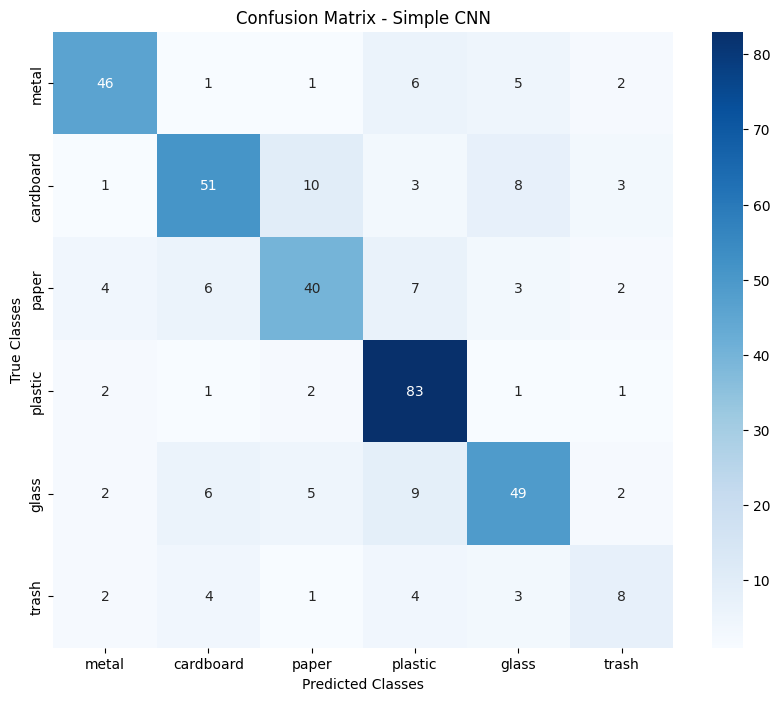

In [ ]:
# Example usage - Evaluate Simple CNN
print("\nEvaluating Simple CNN Model...")
cm_simple, report_simple, specificity_simple, f1_simple = evaluate_model(
    simple_cnn_loaded, test_generator, class_names, model_name="Simple CNN"
)

## **6. Optimized Models**

### **6.1 L2 Regularization and Adam optimizer**

In [ ]:
# Build CNN Model with L2 Regularization and Adam optimizer
def build_l2_cnn_adam(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.001))
    ])

    # Compile with Adam optimizer
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Input dimensions
input_shape = (img_height, img_width, 3)
num_classes = len(class_names)

# Build and summarize model
l2_cnn_adam = build_l2_cnn_adam(input_shape, num_classes)
l2_cnn_adam.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,734 (42.61 MB)

 Trainable params: 11,169,734 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Train the L2-regularized model with Adam optimizer
history_adam = l2_cnn_adam.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 36s 534ms/step - accuracy: 0.2281 - loss: 1.9603 - val_accuracy: 0.2944 - val_loss: 1.6893
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 487ms/step - accuracy: 0.3538 - loss: 1.6085 - val_accuracy: 0.3952 - val_loss: 1.5639
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 508ms/step - accuracy: 0.3834 - loss: 1.5329 - val_accuracy: 0.4191 - val_loss: 1.5351
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 478ms/step - accuracy: 0.4610 - loss: 1.4407 - val_accuracy: 0.4218 - val_loss: 1.5141
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 481ms/step - accuracy: 0.4789 - loss: 1.3626 - val_accuracy: 0.4801 - val_loss: 1.4027
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 480ms/step - accuracy: 0.4758 - loss: 1.3460 - val_accuracy: 0.4801 - val_loss: 1.4371
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 481ms/step - accuracy: 0.4632 - loss: 1.3616 - val_accuracy: 0.4775 - val_loss: 1.3816
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 490ms/step - accuracy: 0.5017 - loss: 1.2731 - val_accu


Evaluating L2-regularized CNN Model with Adam Optimizer...

Confusion Matrix - L2 CNN with Adam
[[40  6  3  8  1  3]
 [ 0 47  9 12  6  2]
 [ 0  9 38  9  2  4]
 [ 0 11  5 68  1  5]
 [ 0 19  2 15 36  1]
 [ 1  7  2  1  1 10]]

Classification Report - L2 CNN with Adam
              precision    recall  f1-score   support

       metal       0.98      0.66      0.78        61
   cardboard       0.47      0.62      0.54        76
       paper       0.64      0.61      0.63        62
     plastic       0.60      0.76      0.67        90
       glass       0.77      0.49      0.60        73
       trash       0.40      0.45      0.43        22

    accuracy                           0.62       384
   macro avg       0.64      0.60      0.61       384
weighted avg       0.66      0.62      0.63       384

Specificity - L2 CNN with Adam
metal: 1.00
cardboard: 0.83
paper: 0.93
plastic: 0.85
glass: 0.96
trash: 0.96
F1 Score - L2 CNN with Adam: 0.63


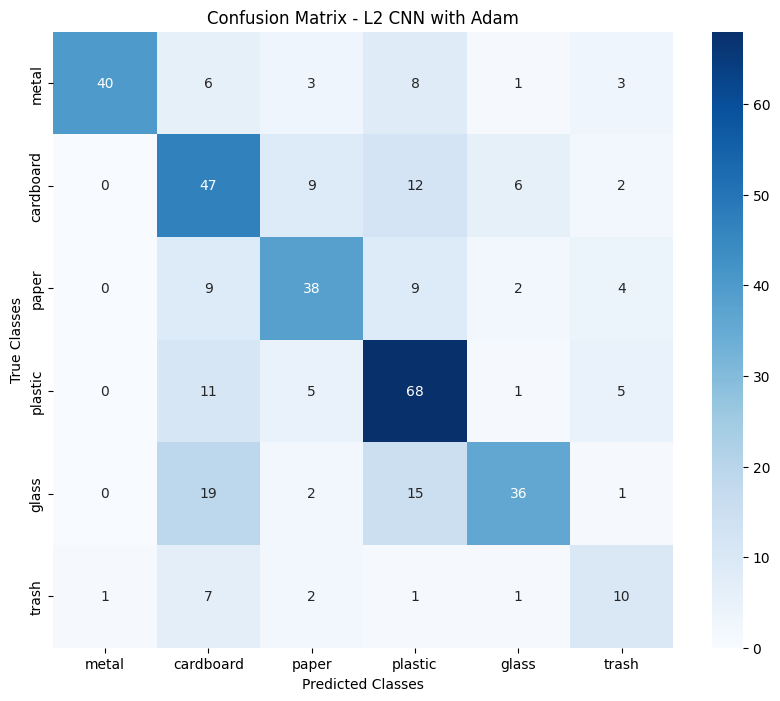

In [ ]:
# Evaluate L2-Adam model
print("\nEvaluating L2-regularized CNN Model with Adam Optimizer...")
cm_adam, report_adam, specificity_adam, f1_adam = evaluate_model(
    l2_cnn_adam, test_generator, class_names, model_name="L2 CNN with Adam"
)


In [ ]:
# Save L2 with Adam Model
l2_cnn_adam_model_path = os.path.join(save_path, 'l2_cnn_adam.keras')
l2_cnn_adam.save(l2_cnn_adam_model_path)
print(f"Simple model saved to {l2_cnn_adam_model_path}")

Simple model saved to /content/drive/MyDrive/Garbage_Classification_Models/l2_cnn_adam.keras


In [ ]:
#Load L2 with adam

l2_cnn_adam_model_path = os.path.join(save_path, 'l2_cnn_adam.keras')
l2_cnn_adam_loaded = tf.keras.models.load_model(l2_cnn_adam_model_path)

### **6.2 L2 Regularization with RMSPROP**

In [ ]:
# Build CNN Model with L2 Regularization and RMSProp optimizer
def build_l2_cnn_rmsprop(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.001))
    ])

    # Compile with RMSProp optimizer
    model.compile(optimizer=RMSprop(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# Build and summarize model
l2_cnn_rmsprop = build_l2_cnn_rmsprop(input_shape, num_classes)
l2_cnn_rmsprop.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,734 (42.61 MB)

 Trainable params: 11,169,734 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the L2-regularized model with RMSProp optimizer
history_rmsprop = l2_cnn_rmsprop.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 502s 8s/step - accuracy: 0.2093 - loss: 3.1116 - val_accuracy: 0.2785 - val_loss: 1.8698
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 225s 4s/step - accuracy: 0.3107 - loss: 1.8092 - val_accuracy: 0.3581 - val_loss: 1.6607
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 267s 4s/step - accuracy: 0.3748 - loss: 1.6199 - val_accuracy: 0.4721 - val_loss: 1.4579
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 253s 4s/step - accuracy: 0.4185 - loss: 1.4818 - val_accuracy: 0.4111 - val_loss: 1.7506
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - accuracy: 0.4738 - loss: 1.4118 - val_accuracy: 0.4748 - val_loss: 1.4509
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - accuracy: 0.5228 - loss: 1.2795 - val_accuracy: 0.4695 - val_loss: 1.4429
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 265s 4s/step - accuracy: 0.5128 - loss: 1.2931 - val_accuracy: 0.5438 - val_loss: 1.2460
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 222s 4s/step - accuracy: 0.5354 - loss: 1.2508 - val_accuracy: 0.5225 - v


Evaluating L2-regularized CNN Model with RMSProp Optimizer...

Confusion Matrix - L2 CNN with RMSProp
[[40  4  2  9  4  2]
 [ 0 42 13 11  9  1]
 [ 0  3 47  7  2  3]
 [ 1  1  4 83  1  0]
 [ 1  5  4 14 49  0]
 [ 0  2  1  2  3 14]]

Classification Report - L2 CNN with RMSProp
              precision    recall  f1-score   support

       metal       0.95      0.66      0.78        61
   cardboard       0.74      0.55      0.63        76
       paper       0.66      0.76      0.71        62
     plastic       0.66      0.92      0.77        90
       glass       0.72      0.67      0.70        73
       trash       0.70      0.64      0.67        22

    accuracy                           0.72       384
   macro avg       0.74      0.70      0.71       384
weighted avg       0.74      0.72      0.71       384

Specificity - L2 CNN with RMSProp
metal: 0.99
cardboard: 0.95
paper: 0.93
plastic: 0.85
glass: 0.94
trash: 0.98
F1 Score - L2 CNN with RMSProp: 0.71


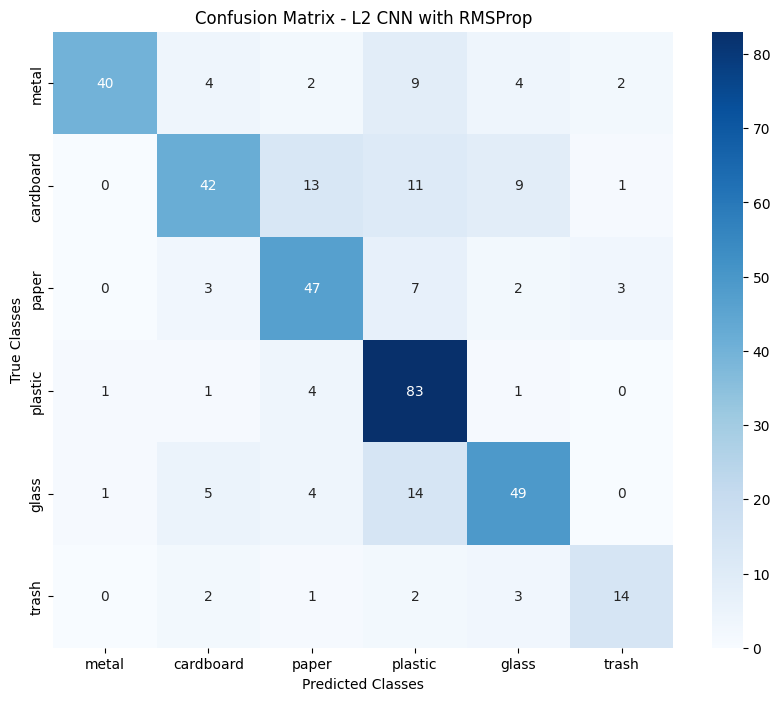

In [ ]:
# Evaluate L2-RMSProp model
print("\nEvaluating L2-regularized CNN Model with RMSProp Optimizer...")
cm_rmsprop, report_rmsprop, specificity_rmsprop, f1_rmsprop = evaluate_model(
    l2_cnn_rmsprop, test_generator, class_names, model_name="L2 CNN with RMSProp"
)

In [ ]:
# Save L2 with Rmsprop Model
l2_cnn_rmsprop_model_path = os.path.join(save_path, 'l2_cnn_rmsprop.keras')
l2_cnn_rmsprop.save(l2_cnn_rmsprop_model_path)
print(f"Simple model saved to {l2_cnn_rmsprop_model_path}")

Simple model saved to /content/drive/MyDrive/Garbage_Classification_Models/l2_cnn_rmsprop.keras


### **6.3 Simple Model With Only Adam Optimisation and Learning Rate**

In [ ]:
# Model With Adam and Earlystopping
def build_adam_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

input_shape = (img_height, img_width, 3)
num_classes = len(class_names)

adam_cnn = build_adam_cnn(input_shape, num_classes)
adam_cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,734 (42.61 MB)

 Trainable params: 11,169,734 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Train Adam CNN
history_adam_e = adam_cnn.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 224s 4s/step - accuracy: 0.2210 - loss: 2.1273 - val_accuracy: 0.4244 - val_loss: 1.4883
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 269s 4s/step - accuracy: 0.4024 - loss: 1.4716 - val_accuracy: 0.5013 - val_loss: 1.3113
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 259s 4s/step - accuracy: 0.4797 - loss: 1.2945 - val_accuracy: 0.4589 - val_loss: 1.4517
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 254s 4s/step - accuracy: 0.4710 - loss: 1.2566 - val_accuracy: 0.5119 - val_loss: 1.2958
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 219s 4s/step - accuracy: 0.5578 - loss: 1.1228 - val_accuracy: 0.5146 - val_loss: 1.2713
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 217s 4s/step - accuracy: 0.5277 - loss: 1.1712 - val_accuracy: 0.5305 - val_loss: 1.2259
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 265s 4s/step - accuracy: 0.5810 - loss: 1.1092 - val_accuracy: 0.5385 - val_loss: 1.2783
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 259s 4s/step - accuracy: 0.6036 - loss: 1.0339 - val_accuracy: 0.5836 - v


Evaluating CNN Model with Adam Optimizer...

Confusion Matrix - CNN with Adam
[[50  3  0  3  5  0]
 [ 2 51  5 10  8  0]
 [ 1  9 34 10  7  1]
 [ 3  2  1 82  0  2]
 [ 1  8  6 16 42  0]
 [ 1  5  1  2  2 11]]

Classification Report - CNN with Adam
              precision    recall  f1-score   support

       metal       0.86      0.82      0.84        61
   cardboard       0.65      0.67      0.66        76
       paper       0.72      0.55      0.62        62
     plastic       0.67      0.91      0.77        90
       glass       0.66      0.58      0.61        73
       trash       0.79      0.50      0.61        22

    accuracy                           0.70       384
   macro avg       0.72      0.67      0.69       384
weighted avg       0.71      0.70      0.70       384

Specificity - CNN with Adam
metal: 0.98
cardboard: 0.91
paper: 0.96
plastic: 0.86
glass: 0.93
trash: 0.99
F1 Score - CNN with Adam: 0.70


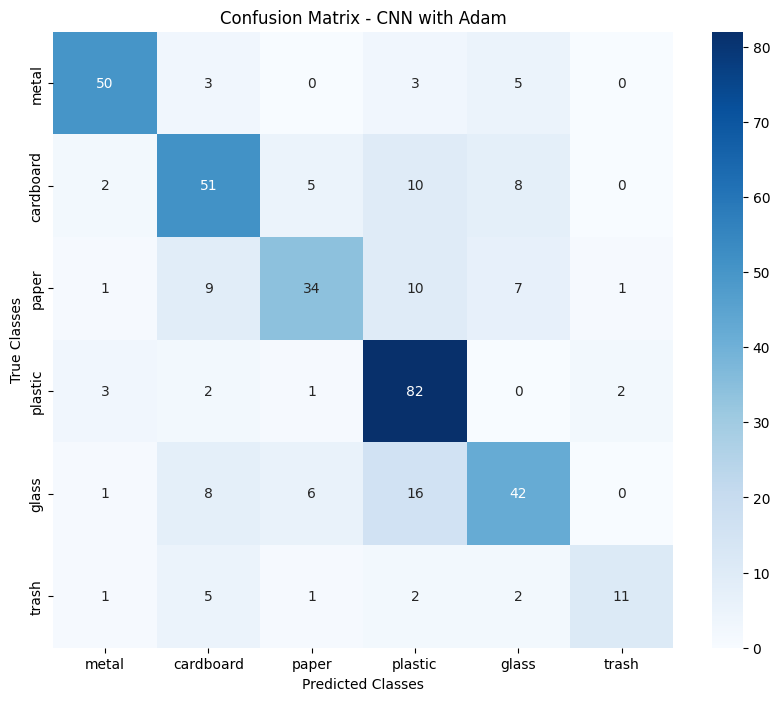

In [ ]:
# Evaluate Adam model
print("\nEvaluating CNN Model with Adam Optimizer...")
cm_adam, report_adam, specificity_adam, f1_adam = evaluate_model(
    adam_cnn, test_generator, class_names, model_name="CNN with Adam"
)

In [ ]:
# Save Adam Model
adam_cnn_model_path = os.path.join(save_path, 'adam_cnn.keras')
adam_cnn.save(adam_cnn_model_path)
print(f"Simple model saved to {adam_cnn_model_path}")

Simple model saved to /content/drive/MyDrive/Garbage_Classification_Models/adam_cnn.keras


### **6.4 L1 Regularization With Adam and Early Stopping**

In [ ]:
# Build CNN Model with L1 Regularization and Adam optimizer
def build_l1_cnn_adam(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.001)),
        layers.Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l1(0.001))
    ])

    # Compile with Adam optimizer
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Input dimensions
input_shape = (img_height, img_width, 3)
num_classes = len(class_names)

# Build and summarize model
l1_cnn_adam = build_l1_cnn_adam(input_shape, num_classes)
l1_cnn_adam.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,734 (42.61 MB)

 Trainable params: 11,169,734 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Train the L1-regularized model with Adam optimizer
history_adam_l1 = l1_cnn_adam.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 323s 6s/step - accuracy: 0.2073 - loss: 36.4881 - val_accuracy: 0.3714 - val_loss: 9.9815
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 530ms/step - accuracy: 0.3496 - loss: 6.6105 - val_accuracy: 0.3926 - val_loss: 2.5828
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 514ms/step - accuracy: 0.3483 - loss: 2.4295 - val_accuracy: 0.3448 - val_loss: 2.1257
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 478ms/step - accuracy: 0.3661 - loss: 2.0810 - val_accuracy: 0.3820 - val_loss: 1.9923
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 463ms/step - accuracy: 0.4208 - loss: 1.9670 - val_accuracy: 0.3263 - val_loss: 2.0012
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 477ms/step - accuracy: 0.4063 - loss: 1.9286 - val_accuracy: 0.3714 - val_loss: 1.9949
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 492ms/step - accuracy: 0.4068 - loss: 1.8846 - val_accuracy: 0.4244 - val_loss: 1.8536
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 506ms/step - accuracy: 0.4199 - loss: 1.8412 - val_accur


Evaluating CNN Model with L1 and Adam Optimizer...

Confusion Matrix - L1 CNN with Adam
[[43  7  3  6  2  0]
 [ 5 30 12 19 10  0]
 [ 6 10 20 24  1  1]
 [ 0 15  3 69  0  3]
 [ 3 17  6 20 27  0]
 [ 3  8  1  7  0  3]]

Classification Report - L1 CNN with Adam
              precision    recall  f1-score   support

       metal       0.72      0.70      0.71        61
   cardboard       0.34      0.39      0.37        76
       paper       0.44      0.32      0.37        62
     plastic       0.48      0.77      0.59        90
       glass       0.68      0.37      0.48        73
       trash       0.43      0.14      0.21        22

    accuracy                           0.50       384
   macro avg       0.51      0.45      0.45       384
weighted avg       0.52      0.50      0.49       384

Specificity - L1 CNN with Adam
metal: 0.95
cardboard: 0.81
paper: 0.92
plastic: 0.74
glass: 0.96
trash: 0.99
F1 Score - L1 CNN with Adam: 0.49


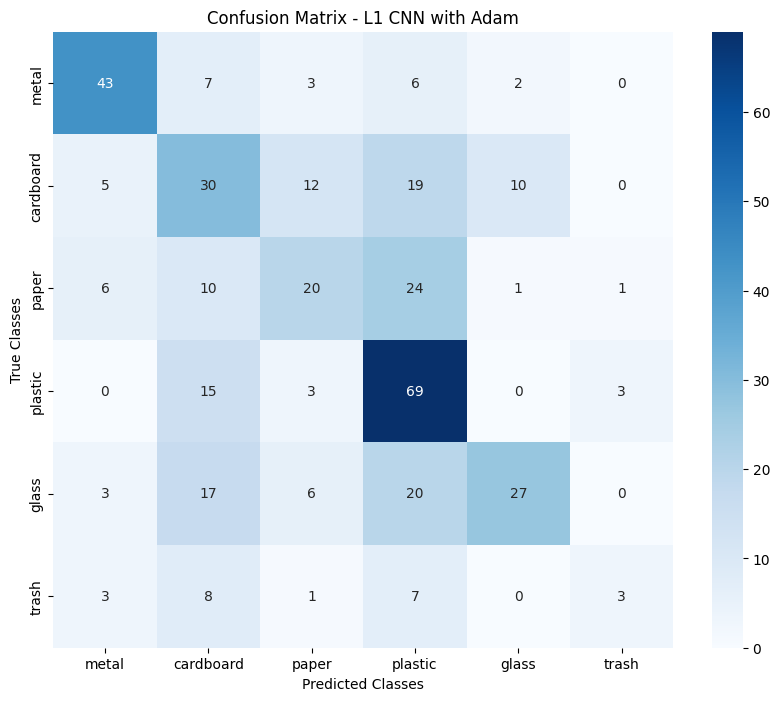

In [ ]:
# Evaluate L1 with Adam model
print("\nEvaluating CNN Model with L1 and Adam Optimizer...")
cm_adam, report_adam, specificity_adam, f1_adam = evaluate_model(
    l1_cnn_adam, test_generator, class_names, model_name="L1 CNN with Adam"
)

In [ ]:
# Save l1 with Adam Model
l1_cnn_adam_model_path = os.path.join(save_path, 'l1_cnn_adam.keras')
l1_cnn_adam.save(l1_cnn_adam_model_path)
print(f"L1 Adam model saved to {l1_cnn_adam_model_path}")

L1 Adam model saved to /content/drive/MyDrive/Garbage_Classification_Models/l1_cnn_adam.keras


## **7. Testing Best Performing Model**
From all the 5 Models I built, The best performing model was Adam optimisation model with Early stopping. Here we test it's prediction accuracy and compare it with the Simple model.

In [ ]:
#Load adam model
adam_cnn_model_path = os.path.join(save_path, 'adam_cnn.keras')
adam_cnn_loaded = tf.keras.models.load_model(adam_cnn_model_path)

In [ ]:
simple_model_path = os.path.join(save_path, 'simple_cnn.keras')
simple_cnn_loaded = tf.keras.models.load_model(simple_model_path)

### Model Evaluation on Test set

In [ ]:
# Evaluate the loaded model on the test set
test_loss, test_acc = simple_cnn_loaded.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Make predictions on the test set using the loaded model
predictions = simple_cnn_loaded.predict(test_generator, verbose=1)

# Get the predicted class indices
predicted_classes = np.argmax(predictions, axis=1)

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Get the ground truth labels from the test generator
true_classes = test_generator.classes

# Create a classification report
from sklearn.metrics import classification_report

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)


12/12 ━━━━━━━━━━━━━━━━━━━━ 215s 19s/step - accuracy: 0.7290 - loss: 0.7756
Test Accuracy: 72.14%
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step
              precision    recall  f1-score   support

   cardboard       0.81      0.75      0.78        61
       glass       0.74      0.67      0.70        76
       metal       0.68      0.65      0.66        62
       paper       0.74      0.92      0.82        90
     plastic       0.71      0.67      0.69        73
       trash       0.44      0.36      0.40        22

    accuracy                           0.72       384
   macro avg       0.69      0.67      0.68       384
weighted avg       0.72      0.72      0.72       384



In [ ]:
print(test_generator.class_indices)

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


### **7.1 Predictions With Simple CNN Model**

12/12 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step


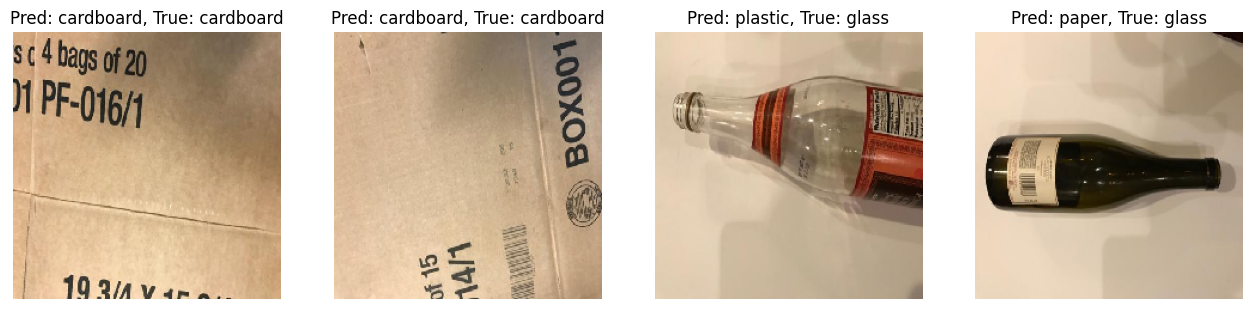

In [ ]:
# Mapping from indices to class names
class_names = list(test_generator.class_indices.keys())

# Get the true labels from the test_generator
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Predict using the loaded model
test_generator.reset()
preds = simple_cnn_loaded.predict(test_generator, verbose=1)
predicted_classes = np.argmax(preds, axis=1)

# Compare predictions with true labels and visualize
plt.figure(figsize=(20, 10))

for i in range(4):
    # Get the image and its true label
    img, label = test_generator[i]
    true_label = class_labels[np.argmax(label[0])]

    # Get the predicted label
    predicted_label = class_names[predicted_classes[i]]

    # Show the image with the predicted and true label
    plt.subplot(2, 5, i + 1)
    plt.imshow(img[0])
    plt.title(f"Pred: {predicted_label}, True: {true_label}")
    plt.axis('off')

plt.show()

### **7.2 Predictions with Adam optimiser model**

12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step


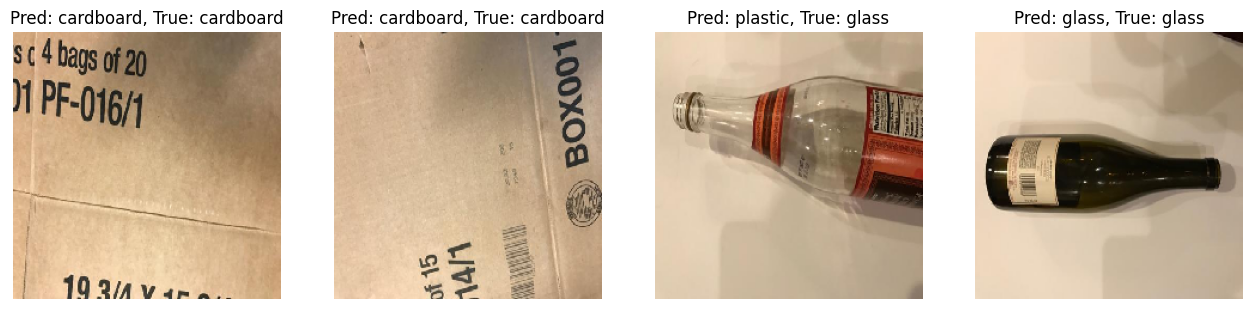

In [ ]:
# Mapping from indices to class names
class_names = list(test_generator.class_indices.keys())

# Get the true labels from the test_generator
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Predict using the loaded model
test_generator.reset()
preds = adam_cnn_loaded.predict(test_generator, verbose=1)
predicted_classes = np.argmax(preds, axis=1)

# Compare predictions with true labels and visualize
plt.figure(figsize=(20, 10))

for i in range(4):
    # Get the image and its true label
    img, label = test_generator[i]
    true_label = class_labels[np.argmax(label[0])]

    # Get the predicted label
    predicted_label = class_names[predicted_classes[i]]

    # Show the image with the predicted and true label
    plt.subplot(2, 5, i + 1)
    plt.imshow(img[0])
    plt.title(f"Pred: {predicted_label}, True: {true_label}")
    plt.axis('off')

plt.show()

## **8. Change Classes to Recyclable or Non-recyclable**

Here I changed the 6 classes into 2 classes (Either Recyclable or Non-Recyclable). Since that is the whole idea behind my project.

12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step


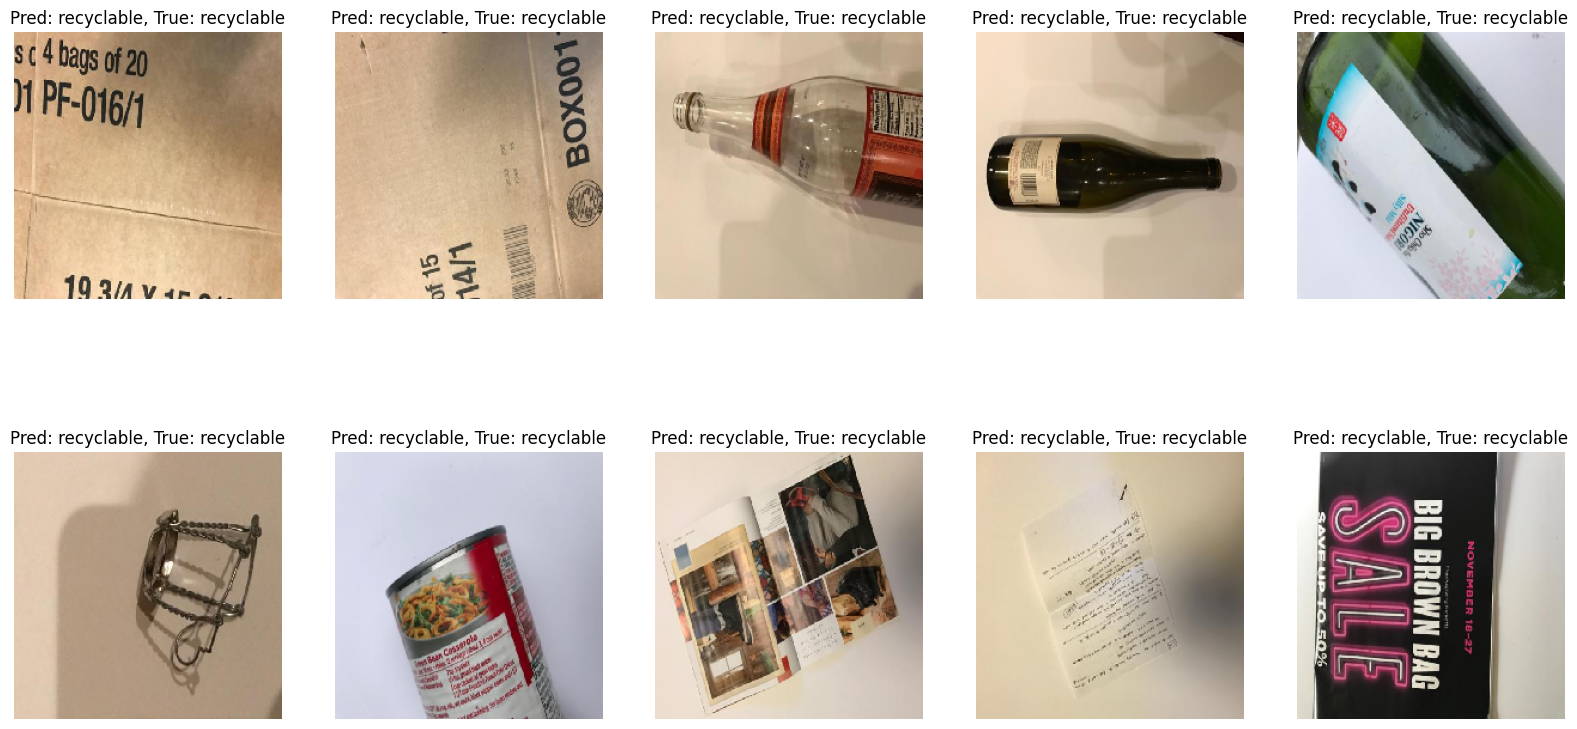

In [ ]:
# Mapping from indices to class names
class_names = list(test_generator.class_indices.keys())

# Define recyclable classes
recyclable_classes = {'metal', 'cardboard', 'paper', 'plastic', 'glass'}

# Get the true labels from the test_generator
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Predict using the loaded model
test_generator.reset()
preds = adam_cnn_loaded.predict(test_generator, verbose=1)
predicted_classes = np.argmax(preds, axis=1)

# Function to convert existing classes to "recyclable" or "non-recyclable"
def convert_to_recyclable_non_recyclable(class_name):
    if class_name in recyclable_classes:
        return "recyclable"
    else:
        return "non-recyclable"

# Compare predictions with true labels and visualize
plt.figure(figsize=(20, 10))

for i in range(10):
    # Get the image and its true label
    img, label = test_generator[i]
    true_label = class_labels[np.argmax(label[0])]

    # Convert true label and predicted label to "recyclable" or "non-recyclable"
    true_category = convert_to_recyclable_non_recyclable(true_label)
    predicted_label = class_names[predicted_classes[i]]
    predicted_category = convert_to_recyclable_non_recyclable(predicted_label)

    # Show the image with the predicted and true category
    plt.subplot(2, 5, i + 1)
    plt.imshow(img[0])
    plt.title(f"Pred: {predicted_category}, True: {true_category}")
    plt.axis('off')

plt.show()

## **Save models as pickle files Instead**

In [ ]:
# Load the simple model
simple_model_path = os.path.join(save_path, 'simple_cnn.keras')
simple_cnn_loaded = tf.keras.models.load_model(simple_model_path)

# Save the simple model as a pickle file
simple_model_pickle_path = os.path.join(save_path, 'simple_cnn.pkl')
with open(simple_model_pickle_path, 'wb') as f:
    pickle.dump(simple_cnn_loaded, f)
print(f"Simple model saved as pickle to {simple_model_pickle_path}")

Simple model saved as pickle to /content/drive/MyDrive/Garbage_Classification_Models/simple_cnn.pkl
